# [IAPR][iapr]: Coin Counter


**Group ID:** 18

**Author 1 (sciper):** Théo Heng (326631)  
**Author 2 (sciper):** Maïka Nogarotto (324757)   
**Author 3 (sciper):** Océane Voland (325144)    

**Release date:** 26.03.2024  
**Due date:** 29.05.2024 (11:59 pm)


## Seting up the Environment

[iapr]: https://github.com/LTS5/iapr

Let's start by importing the relevant packages:

In [1]:
import os
import sys 
import cv2
import timm
import torch
import platform
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix

Then we chose the optimal computation configuration depending on the operating system:

In [2]:
# Check python version is at least python 3.9
assert (sys.version_info.major == 3) and (sys.version_info.minor >= 9)

# Get os name
os_name = platform.system().lower()

# OS X
if 'darwin' in os_name:
    num_workers = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Set the device to mps (Apple Silicon GPU) if availaible for faster computation
    print("Detected OS X, device set to:", device)
# Linux 
elif 'linux' in os_name:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to cuda (NVIDIA GPU) if availaible for faster computation
    num_workers = 8
    print("Detected Linux, device set to:", device) 
# Windows 
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to cuda (NVIDIA GPU) if availaible for faster computation
    num_workers = 0
    print("Detected Windows, device set to:", device)

Detected OS X, device set to: mps


# 1. Introduction

This Notebook is the core of our EE-451 Coin Detection Challenge. Our GitHub repository can be found at [IAPR](https://github.com/Ovoland/IAPR) (private).
In the following work we will build an automatic system that counts the total value of Euros and Swiss Francs on an image.

The dataset we are using for this work is provided by the organizers of this challenge and can be downloaded [here](https://www.kaggle.com/competitions/iapr24-coin-counter/data) (private). The dataset has to be downloaded and added locally by the user.

Running the cells of this Notebook in sequential order, will:

1) Setup the paths and load the data. 
2) Demonstrate our segmentation functions on example images.
3) Generate the train images from the train data (not activated because we annotated manually our images, so we are providing them)
4) Explore different features extraction techniques.
5) Implement and test a template matching
6) Import and configure a deep learning model.
7) Train the model, save the weights and the plots, or load pretrained weights from a local folder. (recommended option)
8) Test the model and generate the submission file.

We are providing the manually annotated images in ```train_preprocessed``` and in ```validation_preprocessed```. Please place those folders in the ```iapr24-coin-counter``` folder. The augmentation has to be done by the user to save weight for the submission (this will be done automatically when running this Notebook).

The folder ```training_results``` contains our best pretrained weights that can be directly loaded by the user to avoid retraining them. It also contains the plots obtained during the training and the related csv file used for the Kaggle submission.

Before starting, make sure the data are located as follows: 

```code
└── iapr24-coin-counter
    └── ref
        ├── ref_chf.JPG
        └── ref_eur.JPG
    └── test
        ├── L0000000.JPG
        ├── ...
        └── L0000161.JPG
    └── train
        ├── 1. neutral_bg
        ├── 2. noisy_bg
        ├── 3. hand
        ├── 4. neutral_bg_outliers
        ├── 5. noisy_bg_outliers
        └── 6. hand_outliers.csv
    └── train_preprocessed
    └── validation_preprocessed
    └── train_labels.csv
    └── sample_submission.csv
├── projet.ipynb
├── report_fig
├── requirements.txt
└── training_results
    └── b0-90.6.csv
    └── b3-96.7.csv
    └── b3-98.4.csv
```

## 1.1 Data setup

#### Set up relevant paths

In [3]:
dataroot = "iapr24-coin-counter"

# Define path to train data
TRAIN_NEUTRAL = os.path.join(dataroot, "train/1. neutral_bg")
TRAIN_NOISY = os.path.join(dataroot, "train/2. noisy_bg")
TRAIN_HAND = os.path.join(dataroot, "train/3. hand")
TRAIN_NEUTRAL_OUTLIERS = os.path.join(dataroot, "train/4. neutral_bg_outliers")
TRAIN_NOISY_OUTLIERS = os.path.join(dataroot, "train/5. noisy_bg_outliers")
TRAIN_HAND_OUTLIERS = os.path.join(dataroot, "train/6. hand_outliers")
TRAIN = [TRAIN_NEUTRAL, TRAIN_NOISY, TRAIN_HAND, TRAIN_NEUTRAL_OUTLIERS, TRAIN_NOISY_OUTLIERS, TRAIN_HAND_OUTLIERS]
TEST  = os.path.join(dataroot, "test")
REFERENCE = os.path.join(dataroot, "ref")

# Check if folder and image exist
for path_train in TRAIN:
    assert os.path.exists(path_train), "Folder not found, please check directory structure"
assert os.path.exists(TEST), "Folder not found, please check directory structure"
assert os.path.exists(REFERENCE), "Folder not found, please check directory structure"

#### Load the training data

In [4]:
valid_images = [".JPG"]

train_dic = {TRAIN_NEUTRAL:[], TRAIN_NOISY:[], TRAIN_HAND:[], TRAIN_NEUTRAL_OUTLIERS:[], TRAIN_NOISY_OUTLIERS:[], TRAIN_HAND_OUTLIERS:[]}
train_data = []

for key, value in train_dic.items():
    # Get the list of files, sort them, then iterate over them
    for f in sorted(os.listdir(key)):
        ext = os.path.splitext(f)[1]
        if ext.upper() not in valid_images:
            continue
        value.append(cv2.imread(os.path.join(key,f)))
        train_data.append(cv2.imread(os.path.join(key,f)))
    print(f"Loaded {len(value)} images from {key[26:]}")

Loaded 16 images from 1. neutral_bg
Loaded 15 images from 2. noisy_bg
Loaded 10 images from 3. hand
Loaded 17 images from 4. neutral_bg_outliers
Loaded 16 images from 5. noisy_bg_outliers
Loaded 7 images from 6. hand_outliers


#### Load the testing data

In [5]:
test_data = []
for f in sorted(os.listdir(TEST))[:]:
    ext = os.path.splitext(f)[1]
    if ext.upper() not in valid_images:
        continue
    test_data.append(cv2.imread(os.path.join(TEST,f)))
print(f"Loaded {len(test_data)} images from test folder")

Loaded 162 images from test folder


#### Load the reference images

In [6]:
ref_img = []
for f in os.listdir(REFERENCE):
    ext = os.path.splitext(f)[1]
    if ext.upper() not in valid_images:
        continue
    ref_img.append(cv2.imread(os.path.join(REFERENCE,f)))

We can display the 2 reference images that contain one or two example of the coins. The first set contains only swiss francs and the second one euros. These type of coins will be found in our training and testing data along with some outsiders.

Let's remind that open CV uses the BGR color format while matplot lib uses RGB. Therefore we need to convert our openCV images into the correct format to be displayed with the correct colors.

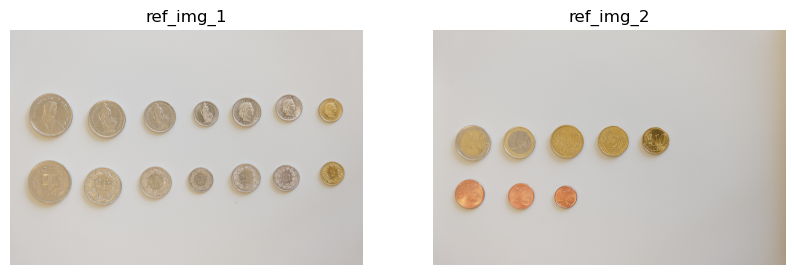

In [7]:
ref_img_1 = np.array(cv2.cvtColor(ref_img[0], cv2.COLOR_BGR2RGB))
ref_img_2 = np.array(cv2.cvtColor(ref_img[1], cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ref_img_1)
ax[1].imshow(ref_img_2)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('ref_img_1')
ax[1].set_title('ref_img_2')
plt.show()

# 2. Segmentation

The main goal of this part is to detect and isolate each coin present on an image. The first step of our pipeline is to determine the type of background of the image, as 3 differents backgrounds are possible with their own type of challenge and difficulties. Then depending on the detected background, we'll pre-process the image to make find the coins more easily. When the coins are localized in the image, we'll crop the coins so that we end up with an image containg the cropped coins with black background.
Finally these images will be used for features extraction and classification. 


### 2.1. Background detection

In this project, only three different type of background are present :
- Neutral : composed of only one white color
- Hand : composed of a lots of HSV colors within the range from (0, 50, 70) to (12, 255, 255), which corresponds to the hand's color
- Noisy : composed of a lots of HSV colors within the range from (85, 50, 50) and (125, 255, 255), which mostly corresponds to the blue/green areas from the background

<br />
<figure>
    <img src="iapr24-coin-counter/train/1. neutral_bg/L1010277.JPG" width="200">
    <figcaption>Neutral background example</figcaption>
</figure>


<div style="display: flex; align-items: center;">
    <figure>
        <img src="iapr24-coin-counter/train/3. hand/L1010373.JPG" width="200">
        <figcaption>Hand background example</figcaption>
    </figure>
    <figure>
        <img src="report_fig/hand_1.png" width="120">
        <figcaption>Lower bound for the hand'color selection</figcaption>
    </figure>
    <figure>
        <img src="report_fig/hand_2.png" width="120">
        <figcaption>Upper bound for the hand'color selection</figcaption>
    </figure>
</div>

<div style="display: flex; align-items: center;">
    <figure>
        <img src="iapr24-coin-counter/train/2. noisy_bg/L1010325.JPG" width="200">
        <figcaption>Noisy background example</figcaption>
    </figure>
    <figure>
        <img src="report_fig/noisy_1.png" width="120">
        <figcaption>Lower bound for the noisy'color selection</figcaption>
    </figure>
    <figure>
        <img src="report_fig/noisy_2.png" width="120">
        <figcaption>Upper bound for the noisy'color selection</figcaption>
    </figure>
</div>

Our first step will be to determine the type of the background of the given image. This decision is based on diffrent thresholding. Indeed, each background contains different specific colors (bluish color for the noisy background and the hand's color for the hand background) so by using appropriate thresholds and computing the number of pixel within each color's range, we could determine the type of background. We assume that if an area larger than 1000000 is detected within one of the two specific color's range, then the image would be associated to the corresponding background. Finally, if no such area is found, then the image is classified with a neutral background. 

Thanks to this function, we would be able to correctly prepare our image based on its background.

In [8]:
def detect_background(img: np.ndarray, show: bool = False):
    """
    Detect the background of the image and returns it
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.medianBlur(img, 5)

    # thresolding corresponding to noisy background
    img_blue = cv2.inRange(img, np.array([85, 50, 50]), np.array([125, 255, 255]))
    area = cv2.countNonZero(img_blue)

    # if the area of the blue background is greater than 1000000, then it is a noisy background
    if area > 1000000:
        if show:
            plt.imshow(img_blue)
            plt.show()
        return "noisy"
    
    # thresholding corresponding to the hand background
    img_hand = cv2.inRange(img, np.array([0, 50, 70]), np.array([12, 255, 255]))
    area = cv2.countNonZero(img_hand)

    # if the area of the hand background is greater than 1000000, then it is a hand background
    if area > 1000000:
        if show:
            plt.imshow(img_hand)
            plt.show()
        return "hand"
    # it the background is not noisy or hand, then it is a neutral background
    return "neutral"

### 2.2. Image preparation

Depending on the type of background, the image preparation would be slightly diffrent, but the main pipeline remains the same :
1) Blurring the image using a Gaussian filter 
2) Apply thresholding to binarize our image into foreground (corresponding to the coins) and background
3) Performing morphological operation to get smoother and nicer coins detected

<figure>
    <img src="report_fig/img_prepared_ex.png" width="400">
    <figcaption>Example of a binary output image after adequate preparation</figcaption>
</figure>

After preparation, the image would be binarized into foreground (corresponding to the coins and display in yellow in the example) and background.

#### 2.2.1 Neutral background

The first type of backgroung we're going to handle is the neutral background. As mentionned before, our goal is to detect the coins knowing what are the main colors of a neutral background. <br>
The blurring step is done using a Gaussian filter acting isotropically on the x and y axis of the image. Then, we apply Contrast Limited Adaptive Histogram Equalization (CLAHE) in order to enhance the local constrat of our image and to avoid noise amplification. Finally, we blur once again our image using a median filter to lastly threhold our image. 

Since this type of background is uniformly colored, only one adaptive thresholding is sufficient in order to separate the coins from the background. Adaptive thresholding algorithm uses a Gaussian weighted sum of the neighborhood values to determine the threshold for each pixel. 

Finally, to get a smoother segmentation and to close potential holes in our segemntated coins, we apply closing and opening operators.

Example of segmentation for a coin from a neutral background


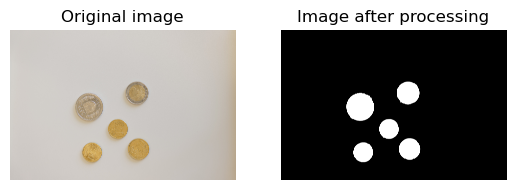

In [9]:
def prepare_image_neutral(img: np.ndarray, show: bool = False):
    """
    Threshold the coins from a neutral background.
    Inputs: img: np.ndarray: Image to process
            show: bool: Flag to determine if the image/processed_image should be displayed
    Output: prepared_img: np.ndarray: Binary processed image, ready for coin detection
    """

    if show:
        fig, axs = plt.subplots(1, 2)
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[0].imshow(display_img)
        axs[0].axis('off')
        axs[0].set_title("Original image")
    
    # Convert image to grayscale
    prepared_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur the image
    prepared_img = cv2.GaussianBlur(prepared_img, (9, 9), 0)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    prepared_img = clahe.apply(prepared_img)

    # Blur the image 3 more times
    prepared_img = cv2.medianBlur(prepared_img, 7)
    prepared_img = cv2.medianBlur(prepared_img, 7)
    prepared_img = cv2.medianBlur(prepared_img, 5)

    # Adaptive thresholding
    prepared_img = cv2.adaptiveThreshold(prepared_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, 5)

    # Invert image
    prepared_img = cv2.bitwise_not(prepared_img)

    # Morph close and open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    prepared_img = cv2.morphologyEx(prepared_img, cv2.MORPH_CLOSE, kernel, iterations=15)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    prepared_img = cv2.morphologyEx(prepared_img, cv2.MORPH_OPEN, kernel, iterations=10)

    if show:
        axs[1].imshow(prepared_img, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title("Image after processing")
        plt.show()
    
    return prepared_img
print("Example of segmentation for a coin from a neutral background")
prepare_image_neutral(train_dic[TRAIN_NEUTRAL][0], show=True);

##### 1.2.1. Noisy background
For this background type, the blurring is done using a median filter, which allows us to already threshold our image. With this background, only one thresholding based on HSV color is done to binarize our image. The lower and upper HSV bound colors are (10, 55, 130) and (22, 255, 255), and are shown here :


<div style="display: flex; align-items: center;">
    <figure>
    <img src="report_fig/prepar_noisy_1.png" width="100">
    <figcaption>Lower bound</figcaption>
</figure>
    <figure>
        <img src="report_fig/prepa_noisy_2.png" width="100">
        <figcaption>Upper bound</figcaption>
    </figure>

</div>


Then, as for the neutral background, opening and closing operation are applied in order to get nicer segmentation results.

Example of segmentation for a coin from a noisy background


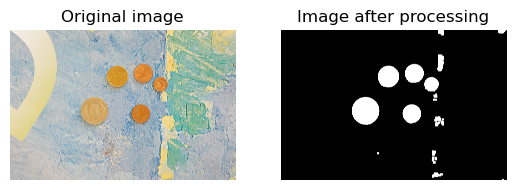

In [10]:
def prepare_image_noisy(img: np.ndarray, show: bool = False):
    """
    Threshold the coins from a noisy background.
    Inputs: img: np.ndarray: Image to process
            show: bool: Flag to determine if the image/processed_image should be displayed
    Output: prepared_img: np.ndarray: Binary processed image, ready for coin detection
    """

    if show:
        fig, axs = plt.subplots(1, 2)
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[0].imshow(display_img)
        axs[0].axis('off')
        axs[0].set_title("Original image")
        
    # Convert image to HSV
    prepared_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Blur the image
    prepared_img = cv2.medianBlur(prepared_img, 5)
    # Threshold the image
    prepared_img = cv2.inRange(prepared_img, np.array([10, 55, 130]), np.array([22, 255, 255]))

    # Morph close and open
    kernel        = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    prepared_img  = cv2.morphologyEx(prepared_img, cv2.MORPH_CLOSE, kernel, iterations=3)
    prepared_img  = cv2.morphologyEx(prepared_img, cv2.MORPH_OPEN, kernel, iterations=13)
    
    if show:
        axs[1].imshow(prepared_img, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title("Image after processing")
        plt.show()
    
    return prepared_img
print("Example of segmentation for a coin from a noisy background")
prepare_image_noisy(train_dic[TRAIN_NOISY][0], show=True);

We observe that some noise coming from the background are detected into the foreground, but these small part don't have a nice circular shape as coin and have smaller areas. Thus, the coin extractor function would not detected them as coin.

##### 1.2.3. Hand background

A median filtering is first performed to blur the image, then, the image is thresholded.

For this type of background, the thresholding step are a bit more complicated because the hand's color is very close to the copper coins thus, two different thresholded images are created, one having only the copper coins left and the other containing all the other coins. Here are the two ranges we use :
- for the copper coins : (11, 65, 150) to (18, 255, 225) expressed in HSV color
- for all the other coins : (19, 15, 150) to (115, 255, 250) and (80, 4, 190) to (95, 8, 255) expressed in HSV color

 Then, on each individual images, closing and opening are perfomed and finally, both images are merged together and returned.

Example of segmentation for a coin from a hand background


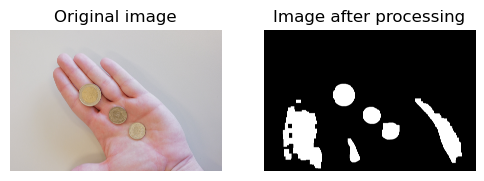

In [11]:
def prepare_image_hand(img: np.ndarray, show: bool = False):
    """
    Threshold the coins from a hand background.
    Inputs: img: np.ndarray: Image to process
            show: bool: Flag to determine if the image/processed_image should be displayed
    Output: prepared_img: np.ndarray: Binary processed image, ready for coin detection
    """

    if show:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[0].imshow(display_img)
        axs[0].axis('off')
        axs[0].set_title("Original image")

    # Convert image to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Blur the image
    img = cv2.medianBlur(img, 5)

    thresholds = [
        (np.array([10, 65, 150]), np.array([18, 255, 225])),  # thresholds for copper coin
        (np.array([19, 15, 150]), np.array([115, 255, 250])), # thresholds for other coins
        (np.array([80, 4, 190]),  np.array([95, 8, 255])),    # thresholds for other coins
    ]
    # Create a binary image for each type of coin and merge them
    merged_img = None
    for lower, upper in thresholds:
        # Threshold the image
        binary_img = cv2.inRange(img, lower, upper)
        # Morph close and invert image
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
        binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=17)
        #remove small objects
        binary_img  = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=15)

        if merged_img is None:
            merged_img = binary_img
        else:
            # Merge the binary images
            merged_img = cv2.bitwise_or(merged_img, binary_img)

    if show:
        axs[1].imshow(merged_img, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title("Image after processing")
        plt.show()
    
    return merged_img
print("Example of segmentation for a coin from a hand background")
prepare_image_hand(test_data[0], show=True);

As for the noisy background, we see that some parts of the hand are detected into the foreground but these have not a circular shape thus, during the coin extraction step, these noisy parts would not be detected as coins.

### 2.3. Coin extraction

Now that our images have been binarized meaning that all the coins are contained into the foreground. This will allows us to find each individual coins from the images. 

This function takes the prepared image and applies cv2.HoughCircles (the parameters sligtly change depending on the background) on it. This cv2 function is able to detect circles contained into an image and to return their center coordinates and their radius. Thus, find_coin function outputs an array of size Nx3 where N is the number of coins present in the image. The first column contains the x-coordinate of the circle center, the second its y-coordinate and the third column contains its radius.

On top of that, this function will draw a circle around each detected coins, add a red dot at its center and write its number directly on the image.

<figure>
    <img src="report_fig/find_coins_ex.png" width="400">
    <figcaption>Annotated image by find_coin function</figcaption>
</figure>

Let's have a closer look at what does this function :
1) the prepared image is blurred 
2) cv2.HoughCircles is applied with sligtly different parameters depending on the background. These differences are due to the fact that the level of noise contained into the foreground are not the same for each background. Indeed, as observed previously, no more noise are contained into the foreground for neutral background whereas, for the noisy and hand backgrounds, some non-circular shapes are still contained into the foreground. Thus, the parameters should be adaptated for each background in order to ensure that these noisy shapes are not detected as circles by cv2.HoughCircles.
3) annotated the image with the detected circles

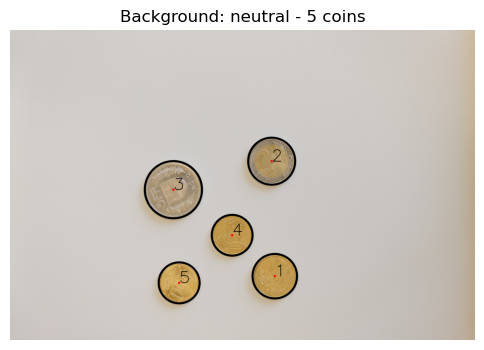

In [12]:
def find_coins(prepared_img: np.ndarray, original_img: np.ndarray = None, background: str = "neutral", show: bool = False):
    """
    Detect the coins in the image and return the number of coins, their positions and their radius.
    Inputs: prepared_img: np.ndarray: Binary processed image, ready for coin detection
            original_img: np.ndarray: Original image
            background: str: Background of the image
            show: bool: Flag to determine if the image/processed_image should be displayed
    Output: circles: np.ndarray: Detected coins, returned as a list of circles (x, y, radius)
    """

    disp_img = original_img.copy()

    # Blur the image
    blur = cv2.blur(prepared_img, (11, 11))

    # detect circles 
    if background == "neutral":
        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=400,
                            param1=69, param2=22, minRadius=150, maxRadius=400)
    elif background == "noisy":
        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=400,
                            param1=70, param2=26, minRadius=150, maxRadius=400)
    elif background == "hand":
        # circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=400,
        #                     param1=70, param2=28, minRadius=160, maxRadius=400)
        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=400,
                            param1=70, param2=24, minRadius=160, maxRadius=400)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        if show:
            idx = 0
            for i in circles[0, :]:
                idx += 1
                # Draw a circle around the coins and a dot in their center
                cv2.circle(disp_img, (i[0], i[1]), i[2], (0, 0, 0), 25)
                cv2.circle(disp_img, (i[0], i[1]), 2, (0, 0, 255), 25)
                # Write the number of the coin next to the center
                cv2.putText(disp_img, str(idx), i[:2], cv2.FONT_HERSHEY_SIMPLEX, 7, (0, 0, 0), 8)

            plt.imshow(cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Background: {background} - {idx} coins")
            plt.gcf().set_size_inches(6, 6)
            plt.axis('off')
            plt.show()

    return circles

find_coins(prepare_image_neutral(train_dic[TRAIN_NEUTRAL][0]), train_dic[TRAIN_NEUTRAL][0], show=True);

### 2.4. Isolation of the coins

The next step consits of isolating each coin in an individual image, thus one initial image would produce N subimages, where N is the number of coin present. This function takes as inputs the initial images with the list of all its detected circles found previously by find_coins and the index of the coin we want to isolate. 

This function crops the initial image into a smaller one of shape 500x500 centered around the coin's center. Since, the detected coin's center could be imperfect, we add padding to the image to make sure that the coin is always in the center of the cropped image. The size of 500 was decided artbitrally with the only criteria to be greater than the biggest coin. By keeping the same individual image size, we ensure that the coins original sclales are preserved.

Here is shown an example of a cropped image :

<figure>
    <img src="report_fig/7_189.JPG" width="200">
    <figcaption>Cropped image</figcaption>
</figure>


In [13]:
def isolate_coin(img: np.ndarray, circles: list, idx: int):
    """
    Isolate a coin from the image using the detected circles by removing the background.
    Inputs: img: np.ndarray: Original image
            circles: list: Detected circles in the image (x, y, radius)
            idx: int: Index of the circle to isolate
    Output: coin: np.ndarray: Isolated coin, as a square image of fixed size, ready for classification
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Remove the background from the image using a mask
    mask = np.zeros(img.shape[:2], dtype="uint8")
    cv2.circle(mask, circles[0][idx][:2], int(circles[0][idx][2]), 255, -1)
    masked = cv2.bitwise_and(img, img, mask=mask)

    box_length = 500

    # Add padding to the image to make sure the coin is always in the center
    padded = cv2.copyMakeBorder(masked, box_length, box_length, box_length, box_length, cv2.BORDER_CONSTANT, value=0)

    # Adjust the center coordinates for the padding
    center_x = circles[0][idx][0] + box_length
    center_y = circles[0][idx][1] + box_length

    coin = padded[center_y-box_length : center_y+box_length, center_x-box_length : center_x+box_length]
    return coin

### 2.5. Plot and save the coin images

In [14]:
def plot_coins(circles: list, img_rgb: np.ndarray):
    """
    Plot the isolated coins from the image using the detected circles.
    Inputs: circles: list: Detected circles in the image (x, y, radius)
            img_rgb: np.ndarray: Original image
    """
    if len(circles[0]) == 0:
        print("No coins detected.")
        return

    nb_rows = int(len(circles[0])/5)
    if len(circles[0]) % 5 != 0:
        nb_rows += 1

    fig, ax = plt.subplots(nb_rows, 5, figsize=(12, 2.5*nb_rows))
    ax = ax.flatten()

    for i in range(len(circles[0])):
        mask = np.zeros(img_rgb.shape[:2], dtype="uint8")
        cv2.circle(mask, circles[0][i][:2], int(circles[0][i][2]), 255, -1)
        masked = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
        box_length = 500 
        center_x = circles[0][i][0]
        center_y = circles[0][i][1]
        coin = masked[center_y-box_length :center_y + box_length,center_x-box_length :center_x + box_length]
        ax[i].imshow(coin)
        ax[i].axis('off')
        ax[i].set_title('Coin {}'.format(i+1))

    # Hide any unused subplots
    for j in range(i+1, nb_rows*5):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
def save_coin(coin_idx: int, image_idx: int, segmented_coin: np.ndarray, dest: str = dataroot):
    """
    Save the segmented coin as a .JPG file with the name "X_idx" where X is the class of the coin and idx is its ID
    Inputs: coin_idx: int: Index of the coin
            image_idx: int: Index of the image
            segmented_coin: np.ndarray: Segmented coin
            dest: str: Destination folder
    """
    dest_folder = os.path.join(dataroot, dest)
    # Construct the filename
    filename = f"{dest_folder}/_{coin_idx}.JPG"
    # Convert the image to BGR
    segmented_coin = cv2.cvtColor(segmented_coin, cv2.COLOR_RGB2BGR)
    # Save the image
    cv2.imwrite(filename, segmented_coin)

### 2.6. Global segmentation functions and generation of the train set

Previously, individual function have been defined, but now the goal is to create one global function that takes as input an image and creates cropped images for all detected coins.

So segment_image will call individual functions in this order :
1) detect_background
2) prepare_image (for the corresponding background)
3) find_coins
4) isolate_coins
5) plot_coins (if needed)

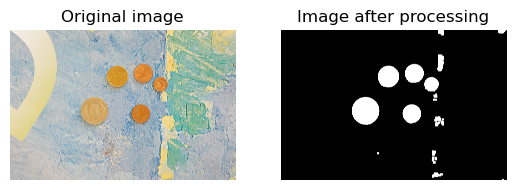

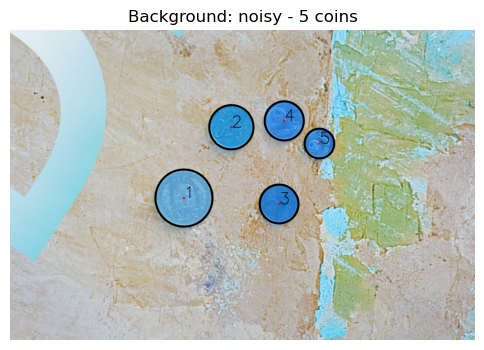

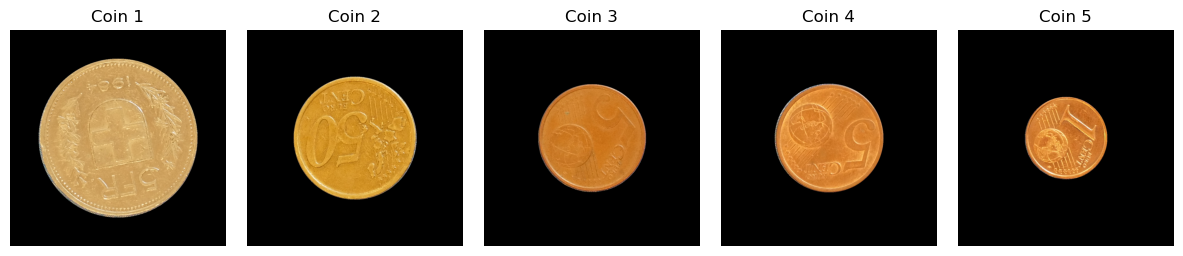

In [16]:
def segment_image(img: np.ndarray, show: bool = False):
    """
    Segment the coins from the image and return the isolated coins.
    Inputs: img: np.ndarray: Image to process
            show: bool: Flag to determine if the image/processed_image should be displayed
    Output: found_coins: list: List of isolated coins
    """

    img_rgb = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    background = detect_background(img)
    
    found_coins = []

    if background == "neutral":
        prepared_image = prepare_image_neutral(img, show)
    elif background == "noisy":
        prepared_image = prepare_image_noisy(img, show)
    elif background == "hand":
        prepared_image = prepare_image_hand(img, show)
    else:
        print("Invalid background type")
        return
    circles = find_coins(prepared_image, img_rgb, background, show)
    if circles is not None:
        for idx in range(len(circles[0])):
                # add the found coin to the list
                found_coins.append(isolate_coin(img, circles, idx))

        if show:
            plot_coins(circles, img_rgb)

        return found_coins

segment_image(train_dic[TRAIN_NOISY][0], show = True);

Then we just need to call this function once for every image in a directory. This is done with the segment_dict function. We also need to save the generated coin images as .JPG loccally on our machine, and this is done by the save_coin function.

In [17]:
def segment_dict(img_dic: dict, starting_idx = 0, show: bool = False, back_gd = "all", save: bool = True):
    """
    Segment the coins from the images in the dictionary and save them.
    Inputs: img_dic: dict: Dictionary of images to process
            starting_idx: int: Index to start the coins at
            show: bool: Flag to determine if the image/processed_image should be displayed
            back_gd: str: Decide what background type should be processed
            save: bool: Flag to determine if the coins should be saved locally
    Output: coin_idx: int: Index of the last coin saved, to avoid overwriting already saved coins
    """

    image_idx = 0
    coin_idx  = starting_idx

    # Loop over the images in the input list
    for value in img_dic:
        image_idx += 1

        img_rgb = np.array(cv2.cvtColor(value, cv2.COLOR_BGR2RGB))
        background = detect_background(value)

        if (background == "noisy" and back_gd == "noisy") or (background == "noisy" and back_gd == "all"):
            prepared_image = prepare_image_noisy(value)
        elif (background == "hand" and back_gd == "hand") or (background == "hand" and back_gd == "all"):
            prepared_image = prepare_image_hand(value)
        elif (background == "neutral" and back_gd == "neutral") or (background == "neutral" and back_gd == "all"):
            prepared_image = prepare_image_neutral(value)
        else:
            continue

        circles = find_coins(prepared_image, img_rgb, background, show=show)

        if circles is None:
            print(f"No coins found in image {image_idx}!")
            continue

        for idx in range(len(circles[0])):
            if save:
                coin = isolate_coin(value, circles, idx)
                # Every 4 coin, save the coin in the validation folder (25% validation, 75% train)
                if coin_idx % 4 == 0:
                    save_coin(coin_idx, image_idx, coin, "validation_preprocessed")
                else: 
                    save_coin(coin_idx, image_idx, coin, "train_preprocessed")
            coin_idx += 1
        print(f"Image {image_idx}/{len(img_dic)} done! {len(circles[0])} coins found,  {background}")
    
    print(f"Found {coin_idx} coins!")
    
    return coin_idx
            
# segment_dict(train_dic[TRAIN_NEUTRAL],          0, show = True, save = False);
# segment_dict(train_dic[TRAIN_NEUTRAL_OUTLIERS], 0, show = True, save = False);
# segment_dict(test_data,                      0, show = True, back_gd = "noisy", save = False);

# GOAL TRAIN: Neutral: 105 Noisy: 82 Hand: 37 Neutral_outliers: 63 Noisy_outliers: 74 Hand_outliers: 21 TOTAL= 382
# CURRENT:    Neutral: 105 Noisy: 82 Hand: 38 Neutral_outliers: 63 Noisy_outliers: 74 Hand_outliers: 21 TOTAL= 383 -> 99,74% 

# GOAL TEST: 162 img: 869 (Neutral: 381, Hand: 122, Noisy: 366)  
# CURRENT:   162 img: 869 (Neutral: 381, Hand: 122, Noisy: 366) -> 100% 

Finally, we call segment_dict for every sub-folder of the train folder with segment_dict_of_dict. This will create exactly 382 coin images, distributed between the train_preprocessed and validation_preprocessed folders (80%-20%). 

#### ``` Important note: the final repartition between train and validation is not really 80/20 but rather 90/10, because some classes were under-represented, and given the small amount of data at our disposal, we decided to add more images to the train set. The final validation set is composed of 3 images of each class (3x15 = 45) and 343 images in the train set. We  alsoremoved coins that weren't well segmented from the train set. ```

The general pipeline for the creation of our train data is then the following:

1) detect_background
2) prepare_image (for the corresponding background)
3) find_coins
4) isolate_coins
5) plot_coins (if needed)
6) save_coin 
7) Annotate manually all of the 382 generated coin images

<figure>
    <img src="report_fig/pipeline.jpg" width="700">
    <figcaption>General pipeline of global segmentation function</figcaption>
</figure>

In [18]:
def segment_dict_of_dict(dict_of_dict: dict, save: bool = False):
    """
    Segment the coins from the images in the dictionary of dictionaries and save them.
    Inputs: dict_of_dict: dict: Dictionary of dictionaries of images to process
    """
    total_coins = 0
    
    for dict_key, dict_value in dict_of_dict.items():

        print(f"Segmenting {dict_key} images...")
        total_coins = segment_dict(dict_value, total_coins, save = save)

#segment_dict_of_dict(train_dic, save = True);

# 3. Feature Extraction

Now that we have isolated coins, it become easier to analyse them and their features. This step will give us a better understanding of what differentiate coins from each others. We'll also implement some methods that will be usefull for further parts.

### 3.1. Reference images

To analyse the different features, we should use the reference images, as they contains all the swiss and french coins type. We need to segment these images to get individual images of each coin.

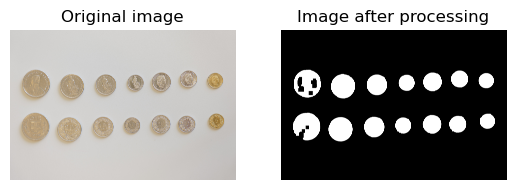

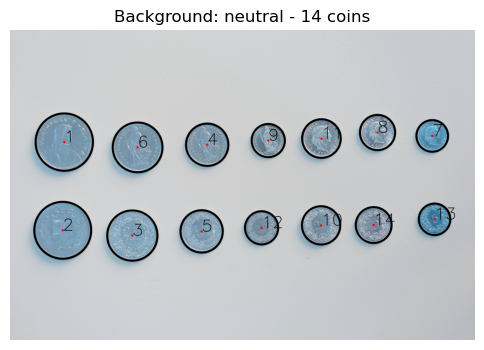

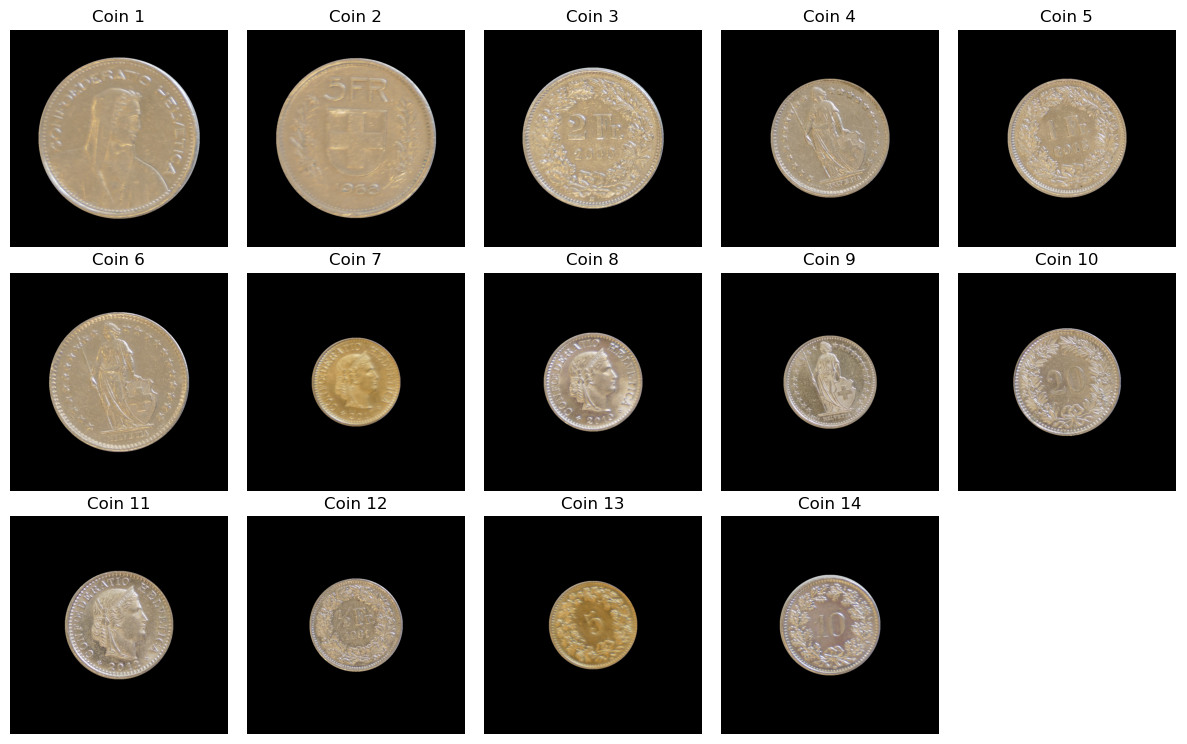

In [19]:
ref_chf = segment_image(ref_img[0], show=True)

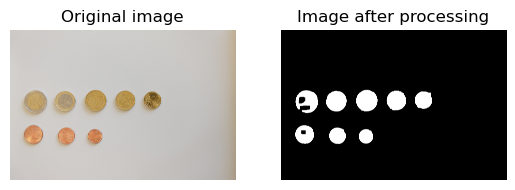

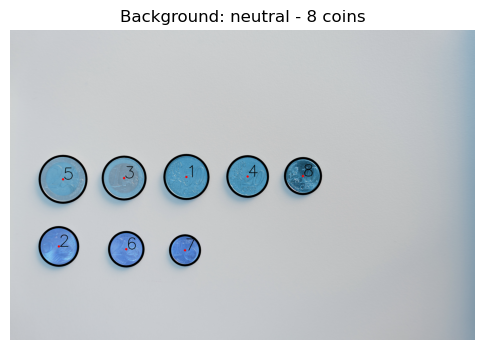

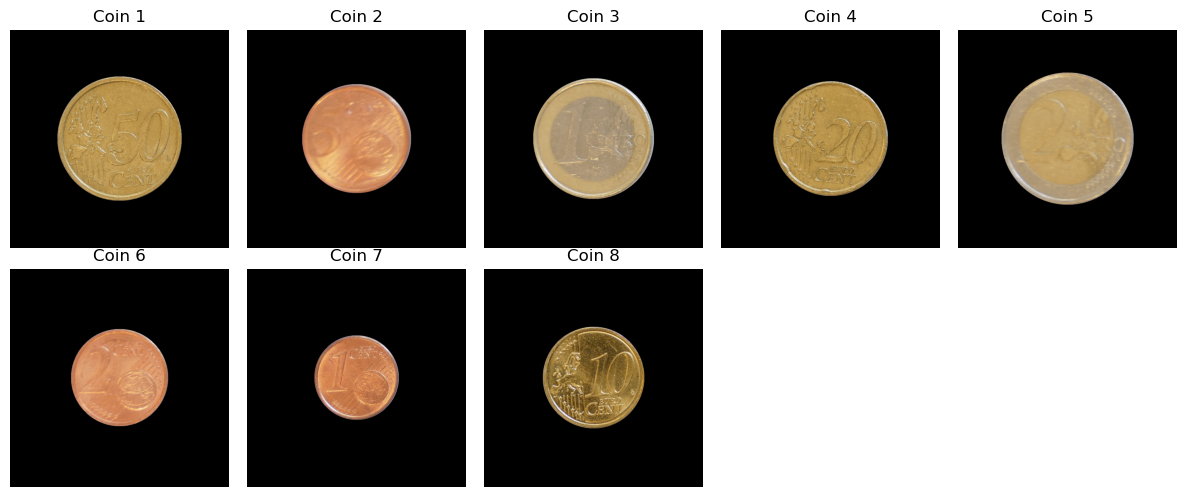

In [20]:
ref_euro = segment_image(ref_img[1], True)

To analyze and keep track of the features extracted more easily let's create dataframe for our reference images. The dataframe will store the index of the coins as defined by the segmentation above. Let's note that have we have multiple examples of some coins, we'll have multiple entries for the same coin value in the dataframe.

In [21]:
money = ["5CHF","2CHF","1CHF","0.5CHF","0.2CHF","0.1CHF","0.05CHF","2EUR","1EUR","0.5EUR","0.2EUR","0.1EUR","0.05EUR","0.02EUR","0.01EUR","OOD"]

In [22]:
data_ref_chf = pd.DataFrame(["5CHF","5CHF","2CHF","1CHF","1CHF","2CHF","0.05CHF","0.1CHF","0.5CHF","0.2CHF","0.2CHF","0.5CHF","0.05CHF","0.1CHF"],columns=["value"])
data_ref_euro = pd.DataFrame(["0.5EUR","0.05EUR","1EUR","0.2EUR","2EUR","0.02EUR","0.01EUR","0.1EUR"],columns=["value"])
data = pd.concat([data_ref_chf, data_ref_euro], ignore_index=True)
data

,value
0,5CHF
1,5CHF
2,2CHF
3,1CHF
4,1CHF
5,2CHF
6,0.05CHF
7,0.1CHF
8,0.5CHF
9,0.2CHF


Now that we have these dataframes, we would be able to store the features associtad to the coin reference just by concatenating new columns.

These coins could be differenciated using different factors, the most obvious ones are probably the shape of the coin, the colors and the symbols on them. 
Let's start with the shape feature.

### 3.2. Shape extraction

As the coins are circles, we can use only one "shape feature" to analyze the, which could be the area, radius or perimeter. Let's remind that the coins have already been segmented and that the background was already set to black. Thus instead of computing again the radius (using HoughCircles and all the rest), it's way faster and more efficient to just count the number of non black pixels, which directly gives us the coin area. 

In [23]:
def get_area(coin : np.ndarray, show: bool =False):
    """
    Get the area of the segmented coin, which corresponds to the number of non-black pixels.
    """
    area = len(coin[coin != 0])
    return area

In [24]:
def extract_area_dict(dict : dict):
    """
    Extract the area of the segmented coins in the dictionary.
    """
    sizes = []
    for img in dict:
        size = get_area(img)
        sizes.append(size)
    return sizes

In [25]:
#Extract the area of the coins
radius_chf = extract_area_dict(ref_chf)
radius_euro = extract_area_dict(ref_euro)
#Add the area to the ref dic
data_ref_chf['area'] = radius_chf
data_ref_euro['area'] = radius_euro
data['area'] = pd.concat([data_ref_chf['area'], data_ref_euro['area']], ignore_index=True)

To have a better vizualisation of this extacted feature, let's plot the area value depending on the coin type. 

In [26]:
def plot_area(data: pd.DataFrame, title: str = "Area of the coins",showline : bool = False,xline: float = 0):
    """
    Plot the area of the coins.
    """
    palette = sns.color_palette(cc.glasbey, n_colors=len(data))
    if('area' not in data.columns):
        print("No area column found in the dataframe")
        return

    sns.scatterplot(data=data, x="area", y="area",color=palette)
    plt.title(title)
    # add annotations one by one with a loop
    for line in range(0,data.shape[0]):
        plt.text(data["area"][line]+0.2, data["area"][line], data["value"][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    if(showline):
        plt.axvline(x=xline,color='r')

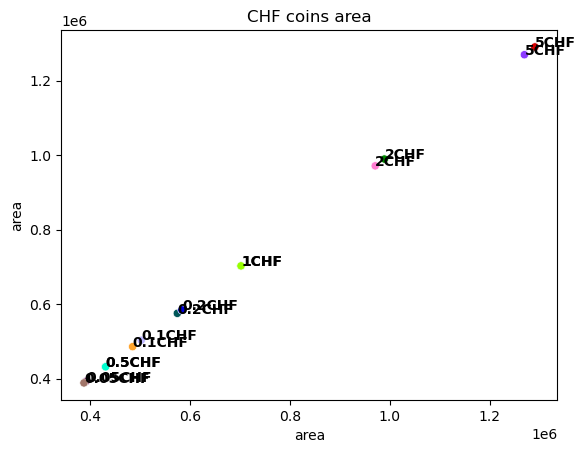

In [27]:
plot_area(data_ref_chf,"CHF coins area")

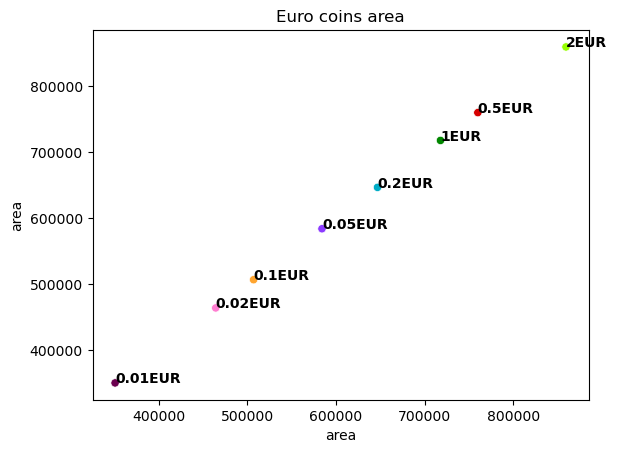

In [28]:
plot_area(data_ref_euro, "Euro coins area")

If origin of the coin is know (french vs swiss), we can see that the radius would be a good feature to differentiate coins. However in our case we don't kown this information.

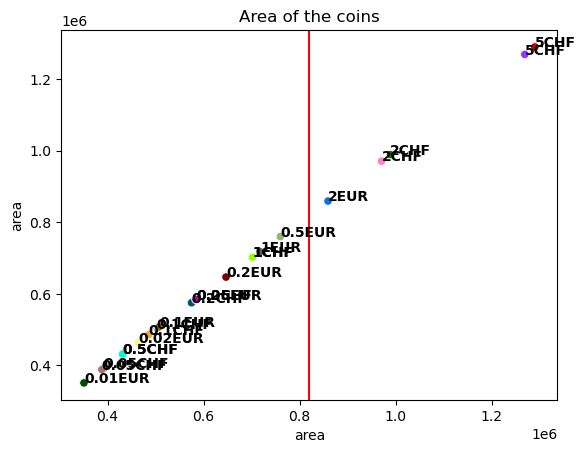

In [29]:
SIZE_THRESHOLD = 8.2e5
plot_area(data,showline=True,xline=SIZE_THRESHOLD)

If we don't know the origin of the coins, the area won't be enough to differentiate the coins, especially the small ones which have very similar sizes.
However it can probably be used to seperate small from big coins which could be usefull to save computational ressources and time. For example we can say that big coins have an area bigger than 8.2e5.

In [30]:
data_ref_chf['size'] = data_ref_chf['area'] > SIZE_THRESHOLD
data_ref_chf['size'] = data_ref_chf['size'].replace({True:"Big",False:'Small'})
data_ref_euro['size'] = data_ref_euro['area'] > SIZE_THRESHOLD
data_ref_euro['size'] = data_ref_euro['size'].replace({True:"Big",False:'Small'})
data_ref_chf.head()

,value,area,size
0,5CHF,1290255,Big
1,5CHF,1269291,Big
2,2CHF,989247,Big
3,1CHF,702363,Small
4,1CHF,702363,Small


In [31]:
chf_big = data_ref_chf[data_ref_chf['size'] == "Big"].index
chf_small = data_ref_chf[data_ref_chf['size'] == "Small"].index
euro_big = data_ref_euro[data_ref_euro['size'] == "Big"].index
euro_small = data_ref_euro[data_ref_euro['size'] == "Small"].index

### 3.3. Contours extraction and enhancement
Coins have visual contours features that could be used to differentiate them. Let's first detect and extract these contours.


In [32]:
def contours_detection(coin:np.ndarray,show:bool = False):
    """
    Detect the contours and details of the coin.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)

    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

    # Sharpen the image
    sharpened_image = cv2.filter2D(gray, -1, kernel)

    # Apply Gaussian blur to reduce noise and detail
    blurred = cv2.GaussianBlur(sharpened_image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 70, 200)

    # Enhance contrast using histogram equalization
    equalized = cv2.equalizeHist(edges)

    contours, hierarchy = cv2.findContours(equalized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and keep the two largest
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    
    coin_contour = coin.copy()
    cv2.drawContours(coin_contour, contours, -1, (0,255,0), 3)
    if(show):
        plt.axis('off')
        plt.imshow(coin_contour)
    return contours

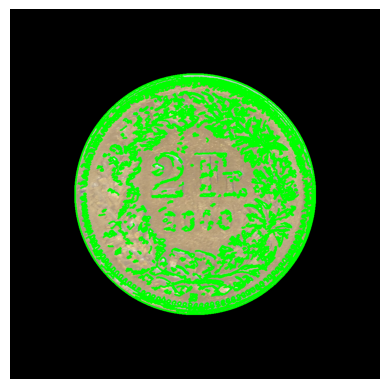

In [33]:
ref_chf2_contours = contours_detection(ref_chf[2],True)

These contours definitively could be used to differentiate coins. For us, the most efficient way of using the contours for coins classification, was to do contours enhancement. By making the contours more visible and prononced, we increase the coin class unique features.

In [34]:
def contours_enhancement(img:np.ndarray,show:bool = False):
    """
    Enhance the contours of the image.
    """
    enhanced_img = img.copy()
    # Convert the image to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

    # Sharpen the image
    sharpened_image = cv2.filter2D(gray, -1, kernel)

    # Apply Gaussian blur to reduce noise and detail
    blurred = cv2.GaussianBlur(sharpened_image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 70, 200)

    # Enhance contrast using histogram equalization
    equalized = cv2.equalizeHist(edges)

    # Enhance the contours
    enhanced_img[equalized == 255] = cv2.add(enhanced_img[equalized == 255], 100)

    if(show):
        plt.axis('off')
        plt.imshow(enhanced_img)
        
    return enhanced_img

It is possible to see down below the effect of the contour enhancement on an example coin.

<div style="display: flex; justify-content: center; align-items: center;">
    <figure>
        <img src="report_fig/contour_enhancement_control.png" width="300">
        <figcaption style="text-align: center;">Control coin</figcaption>
    </figure>
    <figure>
        <img src="report_fig/contour_enhancement_result.png" width="300">
        <figcaption style="text-align: center;">Coin after contours enhancement</figcaption>
    </figure>
</div>

The contour enhancement brings relevant and meaningful improvement and will be used to enhance both training, validation and testing data.

# 4. Classification methods

For this project, we decided to focus on 2 methods that extract other features and classify the coins. We will use a template matching approch and a trained deep learning model. <br>
The first method, only needs the reference images and their associated data (label, area, size) and can directly be used on the testing images without any prior training. Thus this is an semi-supervied method that only need to label the reference images. However the results will probably be lower than the ones obtained with the second method. <br>
On the other hand the deel learning model will need to be trained and fined tuned before beeing applied to the testing data. Model need supervised learning, meaning dataset annotation. But hopefully, results from this model are expected to be higher as the model has more freedom and power of choosing optimzed features for the classification.

## 4.1. Template matching approach

### 4.1.1 Introduction

Template matching is a technic that check a pattern prescence on an image. Meaning that we usually go through the image, comparing each part of the image to our pattern and see which part matches best the pattern. This method allows to determine if the patten is present on an image and where it is located. <br>
For better understanding, it is possible to take a look at the pictures below where the method is illustrated (taken from this [website](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html)). The face of the player is the template and the testing image is the big image. In this example, the template matching is used alongside a square difference option. Notice that the point that matches the most the template (the face of the player) is the darker one. Knowing this it is then possible to determine the localisation of the face.

<div style="display: flex; justify-content: center; align-items: center;">
    <figure>
        <img src="report_fig/template_matching_face.png" width="200">
        <figcaption style="text-align: center;">Face used as a template</figcaption>
    </figure>
<div>

<div style="display: flex; justify-content: center; align-items: center;">
    <figure>
        <img src="report_fig/pattern_matching.png" width="500">
        <figcaption style="text-align: center;">Template matching example</figcaption>
    </figure>
<div>

### 4.2.2 Adaptation of the method

For our project, we'll inspiration from this method and adapt it to suit better our data and challenge. <br>
Our coins in reference images (swiss and french coins) will be used as template. For a given testing coin, we'll determine wich one of the reference coin is the most similar to it. The matching annotated reference coin will determine the nature of our testing coin. <br>
To determine the similarity score between coins, we decided to use the mean of squared difference between the images as it is mentionned on the [template matching openCV webpage](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html). We first took this metrix over the others a bit randomly, but has it was giving good results we decided to keep it. We also compare it to its normalized version, which was giving lower results. <br>
We also tried to use the function `cv2.substract` from open CV, but we get lower results. <br>
The squared difference equation can be found in the [openCV website](https://docs.opencv.org/4.x/df/dfb/group__imgproc__object.html#gga3a7850640f1fe1f58fe91a2d7583695dab65c042ed62c9e9e095a1e7e41fe2773).

<div style="display: flex; justify-content: center; align-items: center;">
    <figure>
        <img src="report_fig/template_matching_equ.png" width="800">
        <figcaption style="text-align: center;">Template matching square difference</figcaption>
    </figure>
<div>

To make more understandable and visual, let's illustrate our pipeline.
If we use this 0.2 CHF as our reference image:

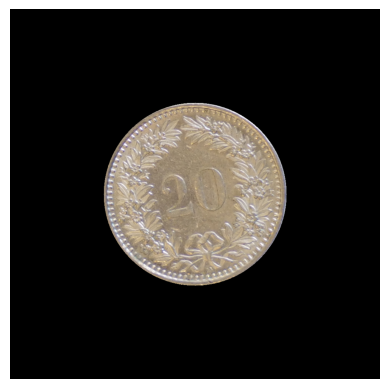

In [35]:
ref_template_matching = ref_chf[9]
plt.axis('off')
plt.imshow(ref_template_matching);

And that we have the following coin as a testing image.

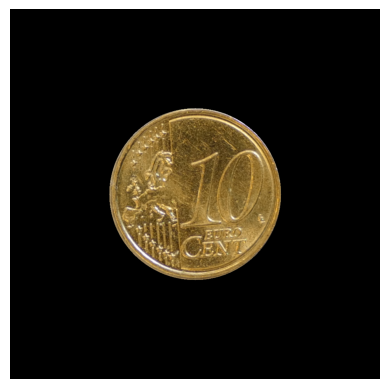

In [36]:
coin_template_matching = ref_euro[7]
plt.axis('off')
plt.imshow(coin_template_matching);

We first convert the images to matrices to be able to have negative value when doing the substraction (otherwise openCV reloop the values to always be positive). Then we apply the formula above and plot the resulting image. Let's note that for the vizualisation we had to divide the pixel value as they were so high that the image was just completely white.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


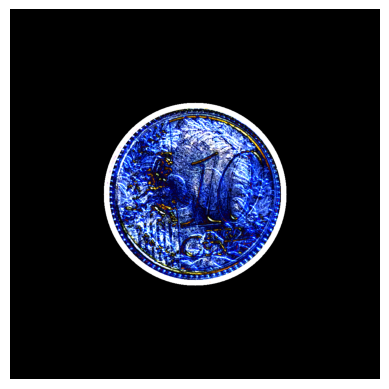

In [37]:
ref_matrix = ref_template_matching.astype("float32")
coin_matrix = coin_template_matching
diff = (ref_matrix - coin_matrix)**2
plt.axis('off')
plt.imshow(diff/10000)

The obtained image shows the squared difference between the 2 images. We can note the difference in coin size is highlighted with a white circle, which are particulary high values. 

After the substraction we take mean of the squared difference, which is used as a metrix of similarities between the coin and the corresponding reference image. <br>
Then we repeat the process for each reference image and keep track of the minimal value and its class. And finally, we determine the class of our coin, by taking the class of the reference image that gives the lowest squared difference. <br>
A quick note considering the outliners, as they aren't part of the reference sets, we had to find a way of classifying coins as outliners. We defined that if the minimal difference between a testing coin and the references images for both sets is greater than 500, then the testing coin is classified as outliner.

### 4.1.3 Implementation

We can find below our implementation of pattern matching.

In [38]:
def pattern_matching(coin : np.ndarray,ref_coins : list,data_ref : pd.DataFrame, compare_size : bool = True):
    coin_area = get_area(coin)
    ref_index = len(ref_coins)

    if(compare_size):
        if(coin_area > SIZE_THRESHOLD):
            ref_index = data_ref[data_ref['size'] == "Big"].index
        else:
            ref_index = data_ref[data_ref['size'] == "Small"].index

    # Let's define a very big value
    min = 50000
    index_min = 0

    coin_matrix = coin.astype("float32")

    for i in ref_index:
        ref_matrix = ref_coins[i].astype("float32")
        diff = (ref_matrix - coin_matrix)**2
        mean_diff = np.mean(diff)
        if(mean_diff < min):
            min = mean_diff
            index_min = i
    return [min,index_min]

This function is used classify a coin using the results of the pattern matching.

In [39]:
def classify_coin(results:pd.DataFrame,index,img:np.ndarray,ref_chf : dict,ref_euro : dict,data_ref_chf:pd.DataFrame,data_ref_euro:pd.DataFrame):
    coin = img.copy()
    [min_chf,index_chf] = pattern_matching( coin, ref_chf,data_ref_chf)
    [min_euro,index_euro] = pattern_matching(coin,ref_euro,data_ref_euro)
    if(min_chf > 500 and  min_euro > 500):
        results["OOD"][index] += 1
    else:
        if(min_chf < min_euro):
            coin_value = data_ref_chf.iloc[index_chf]["value"]
            results[coin_value][index] += 1
        else:   
            coin_value = data_ref_euro.iloc[index_euro]["value"]
            results[coin_value][index] += 1
    return [min_chf,min_euro]

In [40]:
def classify_dict(dict:dict,ref_chf:dict,ref_euro:dict,data_ref_chf:pd.DataFrame,data_ref_euro:pd.DataFrame):
    results = pd.DataFrame(np.zeros((len(dict),len(money))),columns=money)
    for i in range(len(dict)):
        imgs_segmented = segment_image(dict[i])
        if(imgs_segmented is not None):
            for images in imgs_segmented:
                classify_coin(results,i,images,ref_chf,ref_euro,data_ref_chf,data_ref_euro)
    return results

In [41]:
def make_submission(results):
    result_final = results.copy()
    testing_dataframe = pd.read_csv(os.path.join(dataroot, "sample_submission.csv"))
    final_submission = pd.concat([testing_dataframe["id"],result_final],axis=1)
    # Save the dataframe back to the CSV file
    final_submission.to_csv(os.path.join(dataroot, "sample_submission_PM.csv"), index=False)

The cell bellow if uncommented apply this methode to the test datatset. It creates a submission file that can be send on Kaggle to measure the accuracy.

In [42]:
# results = classify_dict(test_data,ref_chf,ref_euro,data_ref_chf,data_ref_euro)
# make_submission(results)

#### 4.1.4 Results

Template matching gives us an accuracy of 66,24% on the Kaggle testing dataset and was run on my device for about 8-9 min.

**Advantages**
- Faster than most machine learning methods
- Only requires a reference images with at least one example of each coin type.
- Only the references images need to be annotated by hand
- Can directly be applied on the testing set without any prior technic
- Transparante pipeline
- Tunable and easy to improve
- Scalable

**Drawbacks**
- Less accurate than most machine learning methods
- Very sensitive to lighting, dirt on coins
- Very sensitive to the set of reference image
- Cropping issues induce a lot of misclassification.
- Has trouble recognizing outliners


**Improvement suggestion**
- Add more images to the reference set
- Create a reference set for outliners
- Create eigen vectors that "fuse" all coins images from the same class
- Try other metrices like cross correlation 
- Rotate the images during the rotations
- Try to blur the images

Overall template matching is a decent method if we have very few data (only the reference images) or that we need something fast and which isn't ressource demanding. In addition this method can certainly be improved. 

## 4.2 Deep learning approach

In this section we will use a model pre-trained on ILSVRC2012 (aka ImageNet-1K) to perform multi-class classification on our segmented images.

### 4.2.1. Data Augmentation

Our training and validation sets are quite small in size (~330 training and ~50 validation coin images), so we decided to augment them. We applied 10 rotations to each image, along with random blurs, hue, and intensity variations, and apply contours enhancement. At the end we ended up with ~3400 training images and ~450 validation images. 

In [43]:
def augment_train_data():
    """
    Augment the training data by rotating the images by 360° by steps of 15°
    Augment the training data by blurring the images with a Gaussian blur
    Augment the training data by altering the brightness of the images
    """
    for img_folder in ["train_preprocessed", "validation_preprocessed"]:
        # Don't augment the folder if it has more than 400 images
        if len(os.listdir(os.path.join(dataroot, img_folder))) > 400:
            print(f"Skipping {img_folder} images. (Already augmented)")
            continue
        for f in os.listdir(os.path.join(dataroot, img_folder)):   
            img = cv2.imread(os.path.join(dataroot, img_folder, f))
            if img is None or img.size == 0:
                continue
            # Enhance the contours of the image
            img_enhanced = contours_enhancement(img)
            cv2.imwrite(os.path.join(dataroot, img_folder, f"{f[:-4]}.JPG"), img_enhanced)
            # Rotate the image by 360° by steps of 15°
            for angle in range(20, 360, 20):
                M = cv2.getRotationMatrix2D((500, 500), angle, 1)
                rotated = cv2.warpAffine(img_enhanced, M, (1000, 1000))
                # Blur some random images
                if np.random.rand() < 0.6:
                    kernel = np.random.choice([3, 5, 7])
                    rotated = cv2.GaussianBlur(rotated, (kernel, kernel), 0)
                # Alter the brightness of some random images
                if np.random.rand() < 0.8:
                    alpha = np.random.uniform(0.92, 1.07)
                    beta = np.random.randint(-55, 55)
                    adjusted = cv2.convertScaleAbs(rotated, alpha=alpha, beta=beta)
                    mask = rotated > 0 # Keep the original background black
                    rotated[mask] = adjusted[mask]
                # Save the augmented image
                cv2.imwrite(os.path.join(dataroot, img_folder, f"{f[:-4]}_{angle}.JPG"), rotated)
        print(f"Augmented {img_folder} images.")

augment_train_data();

Skipping train_preprocessed images. (Already augmented)
Skipping validation_preprocessed images. (Already augmented)


### 4.2.2. Informations about the sets

In [44]:
# Load the CSV files
train_dataframe   = pd.read_csv(os.path.join(dataroot, "train_labels.csv"))
testing_dataframe = pd.read_csv(os.path.join(dataroot, "sample_submission.csv"))

# Extract features and labels for training and testing sets
train_data   = train_dataframe.iloc[:,:]       
# Get the number of unique classes from first row:
num_classes = len(train_data.columns) - 1

classes = {"0": 5,    #CHF
           "1": 2,    #CHF
           "2": 1,    #CHF
           "3": 0.5,  #CHF
           "4": 0.2,  #CHF
           "5": 0.1,  #CHF
           "6": 0.05, #CHF

           "7": 2,    #EUR
           "8": 1,    #EUR
           "9": 0.5,  #EUR
           "10": 0.2, #EUR
           "11": 0.1, #EUR
           "12": 0.05,#EUR
           "13": 0.02,#EUR
           "14": 0.01,#EUR
           
           "15": "OOD",}

size_train, size_validation = train_dataframe["id"], testing_dataframe["id"]

print("Number of classes: {} \n".format(num_classes))

print("Size of training set: {} images".format(size_train.shape[0]))
print("Size of testing set: {} images\n".format(size_validation.shape[0]))

print("Size of preprocessed training set: {} coins".format(len([f for f in os.listdir(os.path.join(dataroot, "train_preprocessed")) if f.endswith(('.JPG'))])))
print("Size of preprocessed testing set: {} coins".format(len([f for f in os.listdir(os.path.join(dataroot, "validation_preprocessed")) if f.endswith(('.JPG'))])))

Number of classes: 16 

Size of training set: 81 images
Size of testing set: 162 images

Size of preprocessed training set: 6012 coins
Size of preprocessed testing set: 810 coins


### 4.2.3. Import and configuration of the model

We decided to use pretrained models for different reasons:
- **Reduced Training Time and Computational Resources:** Training deep neural networks from scratch is computationally intensive and time-consuming. By starting with a pre-trained model, you can leverage the weights and features already learned, which reduces the amount of training time and computational resources required.
- **Better Generalization:** Pre-trained models have already been exposed to a large variety of images and classes, helping them learn general features like edges, textures, shapes, and patterns. These general features are often useful across different datasets, leading to better generalization and improved performance on your specific task.
- **Effective Use of Limited Data:** Fine-tuning is particularly beneficial when you have a limited amount of labeled data for your specific task. The pre-trained model's knowledge serves as a strong foundation, enabling it to learn effectively from fewer examples without overfitting.
- **Robust Feature Extraction:** The initial layers of a pre-trained model capture low-level features (such as edges and textures), while deeper layers capture high-level features (such as object parts and shapes). Fine-tuning allows you to adapt these robust, pre-learned features to your specific dataset, often with only minor adjustments needed. 

We decided to finetune pre-trained EfficientNet Networks because they are lightweight and performant models, easy to use and very accessible thanks to the [Hugging Face](https://huggingface.co) platform. 
EfficientNet is a family of convolutional neural networks (CNNs) designed to achieve high performance with fewer parameters and lower computational cost compared to previous state-of-the-art models. It was developed by Google AI and is based on a novel scaling method that uniformly scales all dimensions of depth, width, and resolution using a compound coefficient.

From this [paper](https://arxiv.org/abs/1905.11946) we know that the backbone of EfficientNet consists of MBConv blocks. These blocks use depthwise separable convolutions to reduce the number of parameters and computations. An MBConv block typically includes:
- **Depthwise Convolution:** Applies a single convolutional filter per input channel, which reduces the computational cost.
- **Pointwise Convolution:** Applies a 1x1 convolution to combine the outputs of the depthwise convolution, effectively reducing the number of parameters.
- **Squeeze-and-Excitation:** This mechanism recalibrates channel-wise feature responses, which helps in boosting the model's accuracy with minimal additional computational cost.

The network is divided into stages, each containing multiple MBConv blocks. As we move deeper into the network, the number of filters increases, but the spatial resolution of the feature maps decreases. This hierarchical structure helps in capturing both low-level and high-level features effectively.

After passing through all the stages, the network includes a global average pooling layer, which reduces each feature map to a single value. This is followed by a fully connected (dense) layer that produces the final classification output.

The EfficientNet family is composed of 8 main models, named EfficientNet_B0 to EfficientNet_B7. B0 is the smaller of them with an input image resolution of 224x224 pixels, and B7 is the larger with a resolution of 600x600 pixels. Instead of scaling up the network dimensions arbitrarily, EfficientNet uses a systematic method to scale up the model's width (number of channels), depth (number of layers), and resolution (input image size) simultaneously and proportionately. This method ensures that the network remains well-balanced and efficient at different scales.

<div style="display: flex; justify-content: center; align-items: center;">
    <figure>
        <img src="report_fig/EfficientNetFamily.png" width="500">
        <figcaption style="text-align: center;">EfficientNet Family</figcaption>
    </figure>
    <figure>
        <img src="report_fig/EfficientNet-architecture.png" width="700">
        <figcaption style="text-align: center;">EfficientNet clever scaling architecture</figcaption>
    </figure>
</div>


We trained all models from B0 to B5, as well as variations of them trained with supposedly more robust data augmentation. As you can see from the graph, EfficientNet B3 is a good trade-off between model size and performance. We also tried a ResNet-50 model.

The general idea when using a pretrained model on a new classification task is the following:

1) Import the model, while making sure to load the pretrained weights by setting the parameter pretrained to True.
2) Change the size of the last layer to have the same number of outputs as we have classes.
3) Freeze the layers that we don't want to re-train.

In the first phase, we tried to freeze all layers and only train the last layer. At this point, we weren't using data augmentation. Our best score on Kaggle with this approach was 87.7%, and was obtained with efficientnet_b5. This is quite impressive given the small amount of data available and the fact that we only trained the last classification layer. However, this model has 30M parameters, and training it multiple times without easy access to a powerful GPU can be time-consuming.

In order to further improve our results, we tried to train the entirety of the models, not only the final layer. We also implemented data augmentation, which multiplied by 10 the size of our datasets. These two major changes drastically increased the computation time, so we had to use smaller models, which resulted in a similar training time as the first approach. Despite smaller models, these improvements in our implementation immediately gave better results, and we managed to obtain 90.6% on Kaggle after 6 epochs of training using efficientnet_b0. This model has 5.3M parameters, which is much smaller than efficientnet_b5. ```Our best performance was obtained with efficientnet_b3 after 4 epochs, reaching 98.4%.```

In [45]:
# Import the model
model_name = "efficientnet_b3" 
model = timm.create_model(model_name, pretrained=True)
# Get the size of the input layer of the classifier
input_layer_size = model.classifier.in_features # (B0 = 1280, B2 = 1408, B3 = 1536, B4 = 1792, B5 = 2048)
model.classifier = nn.Linear(in_features=input_layer_size, out_features=16, bias=True)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

### 4.2.4. Model size and architecture

In [46]:
# Save the model paramters to estimate the size of the model b0 (-> 16.4 MB), b2 (->31.3 MB), b3 (-> 49.5 MB), b4 (-> 71.1 MB), b5 (-> 114.5 MB), b5_aug (-> 114.5 MB), resnet50 (-> 102.5 MB)
torch.save(model.state_dict(), "temp.p")
size = os.path.getsize("temp.p")
os.remove('temp.p')
print(f"Size of {model_name}: {size / (1024 ** 2):.1f} MB")
model = model.to("cpu") # Move the model to the CPU because summary does not work on GPU
# Summary displays the model architecture and the number of parameters by passing dummy data through the network to get the shapes of the layers.
input_size = (3, data_config['input_size'][1], data_config['input_size'][2]) # (C, H, W) -> C = number of channels, H = Height, W = Width
summary(model, input_size)

Size of efficientnet_b3: 41.4 MB
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 144, 144]           1,080
          Identity-2         [-1, 40, 144, 144]               0
              SiLU-3         [-1, 40, 144, 144]               0
    BatchNormAct2d-4         [-1, 40, 144, 144]              80
            Conv2d-5         [-1, 40, 144, 144]             360
          Identity-6         [-1, 40, 144, 144]               0
              SiLU-7         [-1, 40, 144, 144]               0
    BatchNormAct2d-8         [-1, 40, 144, 144]              80
            Conv2d-9             [-1, 10, 1, 1]             410
             SiLU-10             [-1, 10, 1, 1]               0
           Conv2d-11             [-1, 40, 1, 1]             440
          Sigmoid-12             [-1, 40, 1, 1]               0
    SqueezeExcite-13         [-1, 40, 144, 144]               0
      

### 4.2.5. Custom Dataset Class

Here, we define the dataset class that will be used to load the images and their labels while applying the correct transformations required by the model. The dataset class is a subclass of the PyTorch Dataset class. It has to be custom because every project has its own way of storing the data. For example, in our project, the label is the first part of the file name.

We defined a batch size of 32, as it is a pretty standard size given the size of our dataset. In addition, a batch size of 32 allows a good balance between performance and speed of training. Indeed, with a larger batch size, more RAM is required and not all the batch and model data fit in the RAM anymore. This results in much longer trainings because of the memory allocation which is slowing down the process.

However, we still wanted to try larger batch sizes, so we implemented a gradient accumulation. Gradient accumulation is a technique used to handle large models or data that don't fit into memory. It allows us to effectively batch the data in smaller mini-batches, compute the gradients for each mini-batch, and then update the model parameters only after a certain number of mini-batches (accumulation steps) have been processed. So with a step of 2, we only update the model weights and reset the gradient to 0 every 2 batches of 32 images, resulting in an actual batch of 64 images. This allows the model to have more diversity in the data it sees.

Here is a recap of the parameters and results we had for the different models. (trained on 6000 train images, 800 validation, on a M2 Pro with 16GB of RAM)

|                 | Batch size| Accumulation Steps  | Effective Batch Size| Learning Rate | Training time (10 epochs) | Best perfs on Kaggle | NB params
| --------        | --------  | --------            | --------            |  --------     | --------                  | --------             | --------
| EfficientNet B0 | 32        | 1                   | 32                  | 5e-5          | 20 mins                   | 90.6%                | 5.3M
| EfficientNet B3 | 32        | 2                   | 64                  | 5e-5          | 45 mins                   | 98.4%                | 12M
| EfficientNet B4 | 16        | 4                   | 64                  | 5e-5          | 60 mins                   |~98%                 | 19M

In [47]:
class COINs(Dataset):
    """COIN dataset using coin values as classes"""

    def __init__(self, img_dir, transform=None, train = True):
        """
        Args:
            img_dir (str): The directory where the images are stored
            transform (callable, optional): Optional transform to be applied on the image
            target_transform (callable, optional): Optional transform to be applied on the label
        """
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

        # List all the image files in the directory
        self.img_labels = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]

    def __len__(self):
        """Returns the length of the dataset

        Returns:
            int: The length M of the dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Returns the idx-th entry of the dataset

        Args:
            idx (int): the requested entry index of the dataset

        Returns:
            features (torch.Tensor): The image at the idx-th position in the dataset
            label (int): Ground truth label {0, ..., n_classes}
        """
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path)
        
        label = self.img_labels[idx].split('_')[0]  # assuming the label is the first part of the file name
        label = int(label)

        if self.train:
            original_image = self.transform(image)
            return original_image, label
        else:
            image = np.array(image) # convert the PIL image to numpy array
            augmented_image = contours_enhancement(image)
            augmented_image = Image.fromarray(augmented_image) # convert the numpy array to PIL image
            augmented_image = self.transform(augmented_image)
            return augmented_image, label

In [48]:
# Build the train and validation datasets
train_dataset = COINs(os.path.join(dataroot, "train_preprocessed"), transform = transform, train = True)
test_dataset  = COINs(os.path.join(dataroot, "validation_preprocessed"), transform = transform, train = False)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)

### 4.2.6. Training and testing functions

The functions used in this part are pretty standard, and most of them were reused from Lab 3 of this course with only some minor adjustments/adaptations.

We could mention the implementation of a scheduler in the training loop to reduce the learning rate when the loss has not been decreasing for 2 epochs.

We also implemented a confusion matrix, which is called after each epoch. This was very helpful to better understand the weaknesses of our model. We learned that our models were struggling to correctly classify coins of 10 and 20 cents (both CHF and EURO).

In [49]:
@torch.no_grad()
def test(model : nn.Module, test_loader : DataLoader, device : torch.device):
    """The test function, computes the F1 score of the current model on the test_loader

    Args:
        model (nn.Module): The model to evaluate
        test_loader (DataLoader): The test data loader to iterate on the dataset to test

    Returns:
        f1 (float): The F1 score on the given dataset
        loss (float): Averaged loss on the given dataset
    """
    model.eval()

    preds_dict = {"preds" : torch.Tensor(), "labels" : torch.Tensor(), 'losses': torch.Tensor()}
    for features, labels in test_loader:
        # Move the data to the device
        features, labels = features.to(device), labels.to(device)
        # Forward and loss
        preds = model(features)
        loss = F.cross_entropy(preds, labels)
        
        # Store values back to the CPU before storing them in preds_dict. This is because PyTorch tensors on the GPU cannot be converted to NumPy arrays, which is what f1_score requires.
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds.argmax(1).cpu()])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels.cpu()])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None].cpu()])

    # Compute metric and loss
    f1 = f1_score(preds_dict["labels"], preds_dict["preds"], average="macro")
    loss = preds_dict["losses"].mean()

    return f1, loss, preds_dict

In [50]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.

    Args:
        y_true (np.ndarray): The true labels
        y_pred (np.ndarray): The predicted labels
        classes (list): The classes names
        normalize (bool, optional): Whether to normalize the matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to None.
        cmap (colormap, optional): The colormap to use. Defaults to plt.cm.Blues.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [51]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, n_epochs: int, optimizer: torch.optim.Optimizer, device: torch.device, scheduler=None, accumulation_steps=2):
    """Trains the neural network model for n_epochs using a given optimizer on the training dataset.
    Outputs the best model in terms of F1 score on the validation dataset.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): The training dataloader to iterate on the training dataset.
        test_loader (torch.utils.data.DataLoader): The validation dataloader to iterate on the validation dataset.
        n_epochs (int): The number of epochs, i.e., the number of times the model should see each training example.
        optimizer (torch.optim.Optimizer): The optimizer function to update the model parameters.
        device (torch.device): The device to run the training on (e.g., 'cpu' or 'cuda').
        scheduler (optional): The learning rate scheduler.
        accumulation_steps (int, optional): Number of steps to accumulate gradients before updating model parameters. Default is 2.

    Returns:
        best_model (torch.nn.Module): Best model state dictionary.
        best_f1 (float): Best F1-score on the validation set.
        best_epoch (int): Best epoch on validation set.
        val_f1s (list of floats): F1-scores for all epochs.
        val_losses (list of floats): Losses for all validation epochs.
        train_losses (list of floats): Losses for all training epochs.
    """

    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []

    try:
        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            optimizer.zero_grad()

            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()

                # Gradient accumulation
                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()

                running_loss += loss.item()

            # Check if there are any remaining gradients to be updated
            if (batch_idx + 1) % accumulation_steps != 0:
                optimizer.step()
                optimizer.zero_grad()

            train_losses.append(running_loss / len(train_loader))

            # Validation
            model.eval()
            with torch.no_grad():
                f1, val_loss, preds_dict = test(model, test_loader, device)
                y_pred = preds_dict["preds"].numpy()
                y_true = preds_dict["labels"].numpy()

                plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=f"Normalized confusion matrix - Epoch {epoch + 1}")
                plt.savefig(f"confusion_matrix_epoch_{epoch + 1}.png")
                plt.show()

                val_f1s.append(f1)
                val_losses.append(val_loss)

                if scheduler:
                    scheduler.step(val_loss)
                    current_lr = scheduler.optimizer.param_groups[0]['lr']
                else:
                    current_lr = optimizer.param_groups[0]['lr']

                if f1 > best_f1:
                    best_model = model.state_dict()
                    best_f1 = f1
                    best_epoch = epoch + 1

            print(f'Epoch {epoch + 1} - F1: {f1:.3f} - Validation Loss: {val_loss:.3f} - Training Loss: {running_loss / len(train_loader):.3f} - LR: {current_lr:.6f}')

        return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

In [52]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

In [53]:
def extract_ML_feature(model, image, cmap='viridis'):
    """
    Extract and visualize the features from the model.
    
    Parameters:
    - model: The neural network model
    - image: The input image tensor
    - cmap: The colormap to use for visualization
    """
    # Function to capture the output of each conv layer
    def hook_fn(module, input, output):
        if isinstance(module, nn.Conv2d) and not isinstance(module, nn.BatchNorm2d):
            feature_maps.append(output)

    # Register hooks for each layer
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Pass the image through the model
    feature_maps = []
    with torch.no_grad():
        _ = model(image.unsqueeze(0))

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Reverse the feature maps to start from the first layers
    feature_maps.reverse()

    # Visualize feature maps
    for i, fmap in enumerate(feature_maps):
        # Skip layers that are not multiples of 10
        if (i + 1) % 10 != 0:
            continue

        # Get number of feature maps
        num_feature_maps = fmap.shape[1]

        # Skip if the feature map size is 1x1
        if fmap.shape[2] == 1 and fmap.shape[3] == 1:
            continue

        num_display = min(num_feature_maps, 5)

        # Create a grid of subplots
        fig, axes = plt.subplots(1, num_display, figsize=(num_display*2, 2))
        fig.suptitle(f"Layer {i+1}")

        # Plot each feature map
        for j in range(num_display):
            # Get feature map
            img = fmap[0, j].cpu().numpy()

            ax = axes[j] if num_display > 1 else axes
            ax.imshow(img, cmap=cmap)
            ax.axis('off')

        plt.show()


### 4.2.7. Training of the model

This cell will train the selected model for a given number of epochs. Here is a list of the features we implemented for the training (is_training = True):

- The user can chose the optimizer and learning rate, but we found that the classic Adam optimazier was woking just fine for our application.
- Prints at each epoch of the current F1 score, the current train and validation loss, as well as the learning rate, which is dynamically adjusted by the schedueler.
- Plot of the confusion matrix.
- The best model is saved locally.
- Plot of the evolution of the loss and F1 score accross all the epochs at the end of the training.
- The user can stop the training when ever he wants if the remaining epochs are unecessary. The best model state will be saved normally, and the plots will be displayed normally.

If the user don't wan't to train the model from scratch (which takes time), he can chose to load the weights of a pretrained model (is_training = False):

- A model is created and correctly configured.
- The saved weights are loade, and we made sure that the device on which it was trained does not cause problems during this phase, thanks to the map_location parameter.
- The model is loaded to the optimal device and set to eval mode.

Training the model on a local computer is really dependant on the hardware ressources availaible. Training efficient_net_b0 for 10 epochs with a batch size 32 and 12000 train image take around 30 minutes on a M2 Pro chip with 16go of RAM. However, this training time increase drastically for slightly bigger models because of insufficient RAM. This is why we provide pretrained weights, so the user can quickly test the performance of our model without having to go through the traing phase.

In [54]:
best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = None, None, None, None, None, None

training_active = False
model_to_load = "training_results/b3-98.4%/trained_efficientnet_b3.pth"

try:
    if training_active:
        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

        # Define the number of epochs
        epochs = 10

        # Move the model to the optimal device
        model = model.to(device)

        # Run training and display results:
        print(f"Training {model_name} for {epochs} epochs...")
        best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = train(model, train_loader, test_loader, n_epochs=epochs, optimizer=optimizer, device=device, scheduler=scheduler, accumulation_steps=4)
        print(f"Best {model_name} at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

        # Save the state dictionary
        torch.save(best_model, f'trained_{model_name}.pth')

        model.eval();  # Set the model to evaluation mode

        print(f"Succesfully trained and saved {model_name} as trained_{model_name}.pth")

        # Plot the training results
        plot_training(best_epoch, val_accs, val_loss, train_loss)
        plt.savefig(f'{model_name}_training.png') # save the plot

    else:
        if os.path.exists(f'{model_to_load}'):
            model = timm.create_model(model_name, pretrained = False)  # Create a new model
            model.classifier = nn.Linear(in_features=input_layer_size, out_features=16, bias=True)
            model.load_state_dict(torch.load(f'{model_to_load}', map_location=device))  # Load the state_dict
            model = model.to(device)  # Move the model to the device
            model.eval();  # Set the model to evaluation mode
            print(f"Succesfully loaded saved weights for {model_to_load}.")
        else:
            print(f"No pre-trained model found for {model_to_load}.")
        
except KeyboardInterrupt:
    print(f"Best {model_name} at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")
    torch.save(best_model, f'best_{model_name}.pth') # Save the state dictionary
    model.eval();  # Set the model to evaluation mode
    model = model.to(device)  # Move the model to the device
    print(f"Succesfully trained and saved {model_name} as best_{model_name}.pth")
    plot_training(best_epoch, val_accs, val_loss, train_loss) # Plot the training results
    plt.savefig(f'{model_name}_training.png') # save the plot

Succesfully loaded saved weights for training_results/b3-98.4%/trained_efficientnet_b3.pth.


Now that we have a model trained on our dataset, we can have a look at the features that the model extract accross its layers when we present him a coin of 1€.

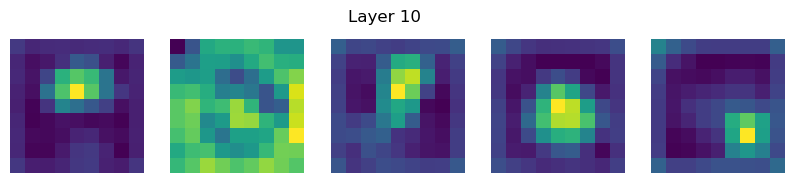

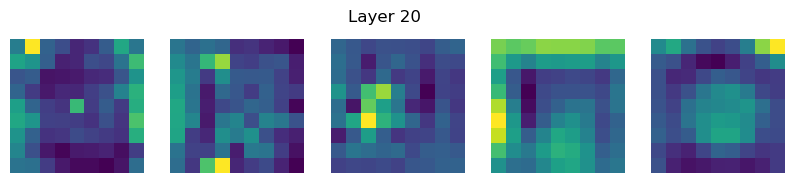

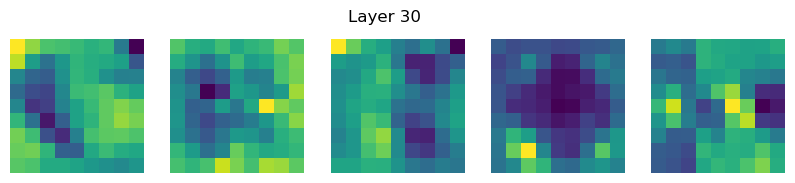

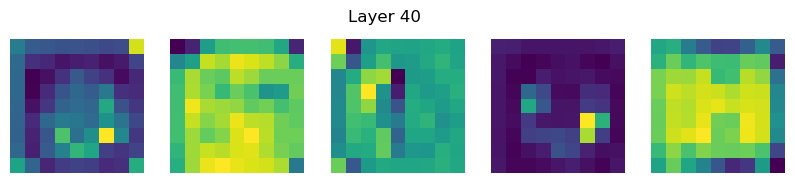

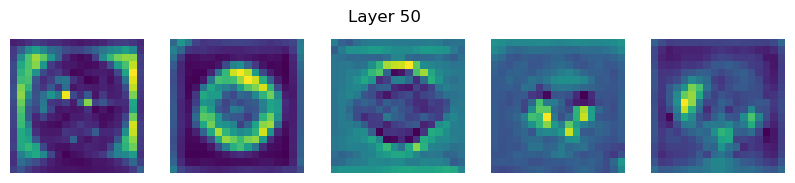

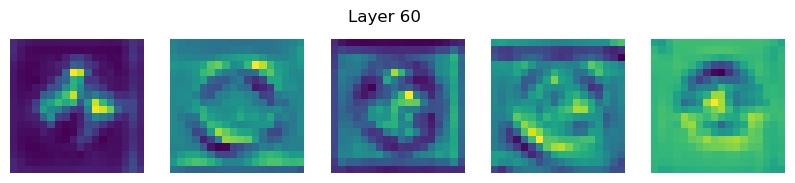

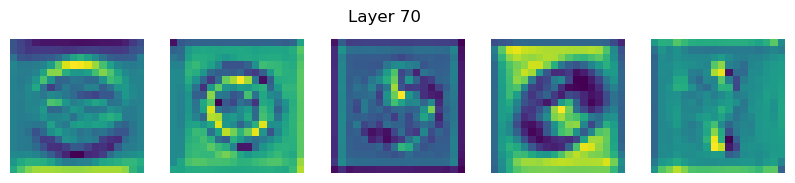

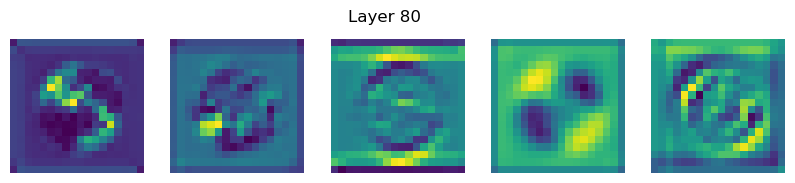

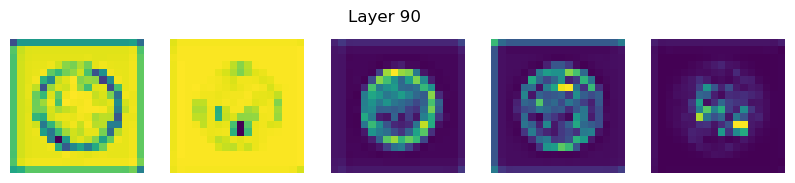

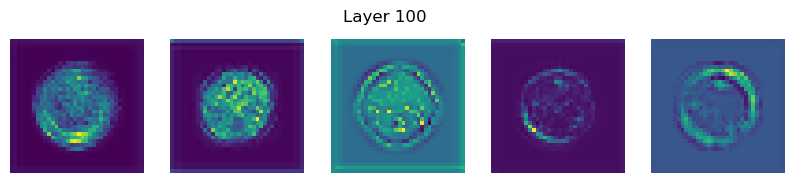

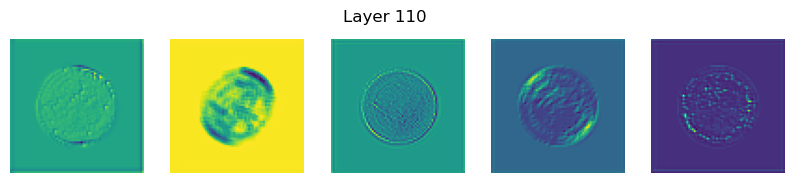

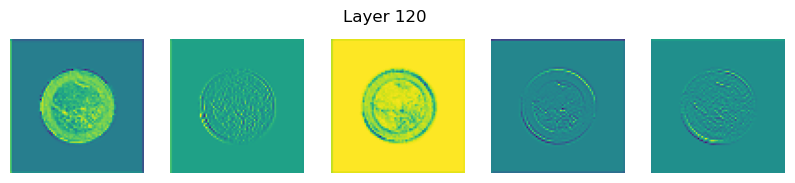

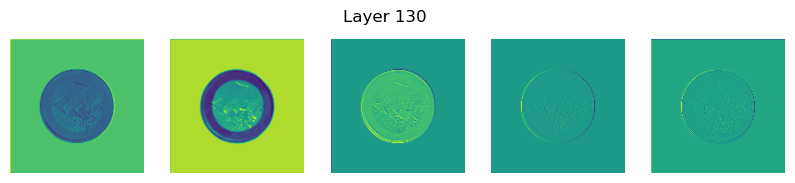

In [55]:
image_for_feature_maps = transform(Image.fromarray(segment_image(test_data[1], show=False)[1])).to(device)
extract_ML_feature(model, image_for_feature_maps)

We observe that the model starts with very rough features, but become more and more precise and detailled as we move deeper in the network.

### 4.2.8. Total sum estimation

The predict image function is a very intuitive function that take an image as input,then segment it into coins images and finally fed tehm one by one to our trained model. The predictions are stored and retured as an array ready to be added in the submission .CSV.

Found 4 coins
Total: 0 €, 11.1 CHF, and 0 OOD


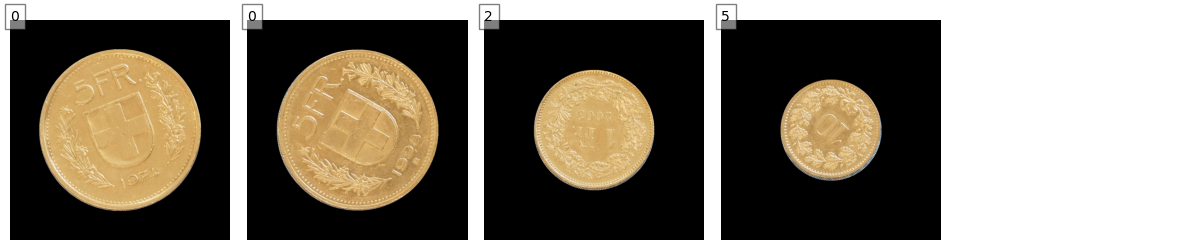

In [56]:
def predict_image(img: np.ndarray, model: nn.Module, classes: dict, show: bool = False):
    # Segment the image into sevreal coins images
    segmented_images = segment_image(np.array(img), show=False)

    if segmented_images is None:
        print("No coins found in the image!")
        return np.array([0]*16)
    
    print(f"Found {len(segmented_images)} coins")

    # Create a figure
    if show:
        nb_rows = int(len(segmented_images)/5)
        if len(segmented_images) % 5 != 0:
            nb_rows += 1

        fig, ax = plt.subplots(nb_rows, 5, figsize=(12, 2.5*nb_rows))
        
        ax = ax.flatten()

        # Display the segmented images
        for i, coin in enumerate(segmented_images):
            ax[i].imshow(coin)
            ax[i].axis('off')

    # Predict the value of each coin using the model
    predictions = []
    for coin in segmented_images:
        #Let's enhance the contours of the coin 
        coin = contours_enhancement(coin)
        coin_pil = Image.fromarray(coin)
        input_data = transform(coin_pil).unsqueeze(0).to(device)
        output = model(input_data)  # unsqueeze single image into batch of 1
        predictions.append(output.argmax().item())

    # Compute the total amount of money
    total_amount_euro   = 0
    total_amount_francs = 0
    nb_OOD = 0
    for prediction in predictions:
        if prediction <= 6:
            total_amount_francs += classes[str(prediction)]
        elif prediction <= 14:
            total_amount_euro += classes[str(prediction)]
        else:
            nb_OOD += 1

    print(f"Total: {round(total_amount_euro,2)} €, {round(total_amount_francs,2)} CHF, and {nb_OOD} OOD")

    # Display the predictions
    if show:
        for i, prediction in enumerate(predictions):
            ax[i].text(0, 0, f"{prediction}", bbox=dict(facecolor='white', alpha=0.5))
        # Hide any unused subplots
        for j in range(i+1, nb_rows*5):
            ax[j].axis('off')
        plt.tight_layout()
        plt.show()

    # Return an array of 16 elements, with 0 for each class except the predicted ones

    predi = np.array([0]*16)
    for i in predictions:
        predi[i] += 1
    return predi

img = cv2.imread(os.path.join("iapr24-coin-counter", "test", "L0000002.JPG"));
predict_image(img, model, classes, show=True);

### 4.2.9. Production of the Deliverable

This simple function iterate over all the test images, calling predict_image. Set show to False if you don't want to plot the predictions while the submission file is generated.

In [57]:
def predict_test(test_data: list, model: nn.Module, classes: dict):
    # Load the CSV file

    testing_dataframe = pd.read_csv(os.path.join(dataroot, "sample_submission.csv"))
    for i, img in enumerate(test_data):

        print(f"Image {i+1}")
        predictions = predict_image(img, model, classes, show=False)
        
        # Replace the 0s in the row with the predictions
        testing_dataframe.iloc[i, 1:] = np.round(predictions, 2)

    # Save the dataframe back to the CSV file
    testing_dataframe.to_csv(os.path.join(dataroot, "sample_submission.csv"), index=False)

predict_test(test_data, model, classes)

Image 1
Found 3 coins
Total: 2 €, 0.4 CHF, and 0 OOD
Image 2
Found 10 coins
Total: 2.55 €, 3.95 CHF, and 0 OOD
Image 3
Found 4 coins
Total: 0 €, 11.1 CHF, and 0 OOD
Image 4
Found 8 coins
Total: 0.12 €, 1.15 CHF, and 2 OOD
Image 5
Found 6 coins
Total: 1.02 €, 1.8 CHF, and 0 OOD
Image 6
Found 8 coins
Total: 0.02 €, 7.3 CHF, and 0 OOD
Image 7
Found 8 coins
Total: 0 €, 10.25 CHF, and 2 OOD
Image 8
Found 6 coins
Total: 0 €, 3.3 CHF, and 1 OOD
Image 9
Found 4 coins
Total: 1 €, 2.5 CHF, and 1 OOD
Image 10
Found 4 coins
Total: 0.9 €, 0.1 CHF, and 0 OOD
Image 11
Found 5 coins
Total: 2.1 €, 0.3 CHF, and 1 OOD
Image 12
Found 8 coins
Total: 4.1 €, 8.2 CHF, and 0 OOD
Image 13
Found 6 coins
Total: 1.1 €, 0.5 CHF, and 0 OOD
Image 14
Found 5 coins
Total: 0.08 €, 1 CHF, and 1 OOD
Image 15
Found 5 coins
Total: 2 €, 2.8 CHF, and 0 OOD
Image 16
Found 5 coins
Total: 0.2 €, 0.05 CHF, and 1 OOD
Image 17
Found 6 coins
Total: 0.01 €, 2.7 CHF, and 0 OOD
Image 18
Found 7 coins
Total: 0.25 €, 7.15 CHF, and 0 OOD


# 5. Conclusion and discussion

#### 5.1. Segmentation

Our segmentation detects automatically the background of the image and apply the optimal thresholding technique to obtain clean image, from which we can easily extract the coins using Hough circles.

This approach allowed us to detect 100% of the training and testing images. The coins are almost always in the exact center of the image, and the background is automatically removed, in order to avoid giving useless informations about the backgroud to the model.

We are happy with those results and think that this part of the project is optimized. However, our approach relies on finetuned thresholds that wouln't generalize well to other type of backgrounds, lightining, ect... 

#### 5.2. Features extraction

To analyze features, we decided to extract them by hand and not to use ML model because the obtained features are generally not meaningfull and interpretable.
In our case, we analyzed only the two following features : 
- area : useful to save running time during our template matching algorithm. Indeed we can choose to compare our testing image with reference images of the same category of size (small vs big).
- contours : allows us to perform contours enhancement which increases the performances of our ML model

We also shown that it was possible to get the features directly from the trained model and plot them. They could have been used for other classification methods (linear classification).

#### 5.3. Classification

#### 5.3.1 Template matching

The template matching approch gives us decent result knowing that we're only using reference images and a fast implementation. However it is outperformed by most machine learning methods and is very weak to lightings and cropping inaccuracies. Plus as the outliners aren't part of the reference image, the approch has more trouble distinguishing them. But hopefully this approch can certainly be improved and can be more easily adjusted or scaled. 


#### 5.3.2 Deep learning approch 

The model we trained gave us very satisfying results and is still 10 times smaller than the limit size allowed for this project. We could have further improved the performance by having more data for the 10 cents and 20 cents (both swiss and french) as they're really similar to each others and hard to classify. We observed on the confusion matrix that these classes were often confused toghther and are the reason why we didn't achieved 100%. We also could have used a bigger model and augment even further the dataset but we didn't have enough computing power to try this approch.

We made the decision to annotate by hand the training and testing segmented coins images to improve our model performance. However we're aware that this option don't scale well and won't always be possible depending on the size of the dataset.
